In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import linregress
from statsmodels.tsa.arima.model import ARIMA
from pyts.decomposition import SingularSpectrumAnalysis
from pmdarima.arima import auto_arima
import warnings
import itertools
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram, find_peaks
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox, normaltest
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import pywt
from sklearn.decomposition import PCA
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.utils.extmath import randomized_svd
from PyEMD import EMD
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from pykalman import KalmanFilter
import torch
import torch.nn as nn
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from astropy.timeseries import LombScargle
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_ind
import datetime
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import correlate
from scipy.fft import fft, fftfreq

# Подавляем только FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
time_series = pd.read_excel("bitcoin.xlsx")

In [3]:
time_series = time_series.sort_values('Дата', ignore_index=True)
time_series

,Дата,Значение
0,2015-05-06,229.780000
1,2015-05-07,237.330000
2,2015-05-08,243.860000
3,2015-05-09,241.830000
4,2015-05-10,240.300000
...,...,...
3607,2025-05-30,104694.787188
3608,2025-05-31,103803.121799
3609,2025-06-01,105233.374133
3610,2025-06-02,104839.027304


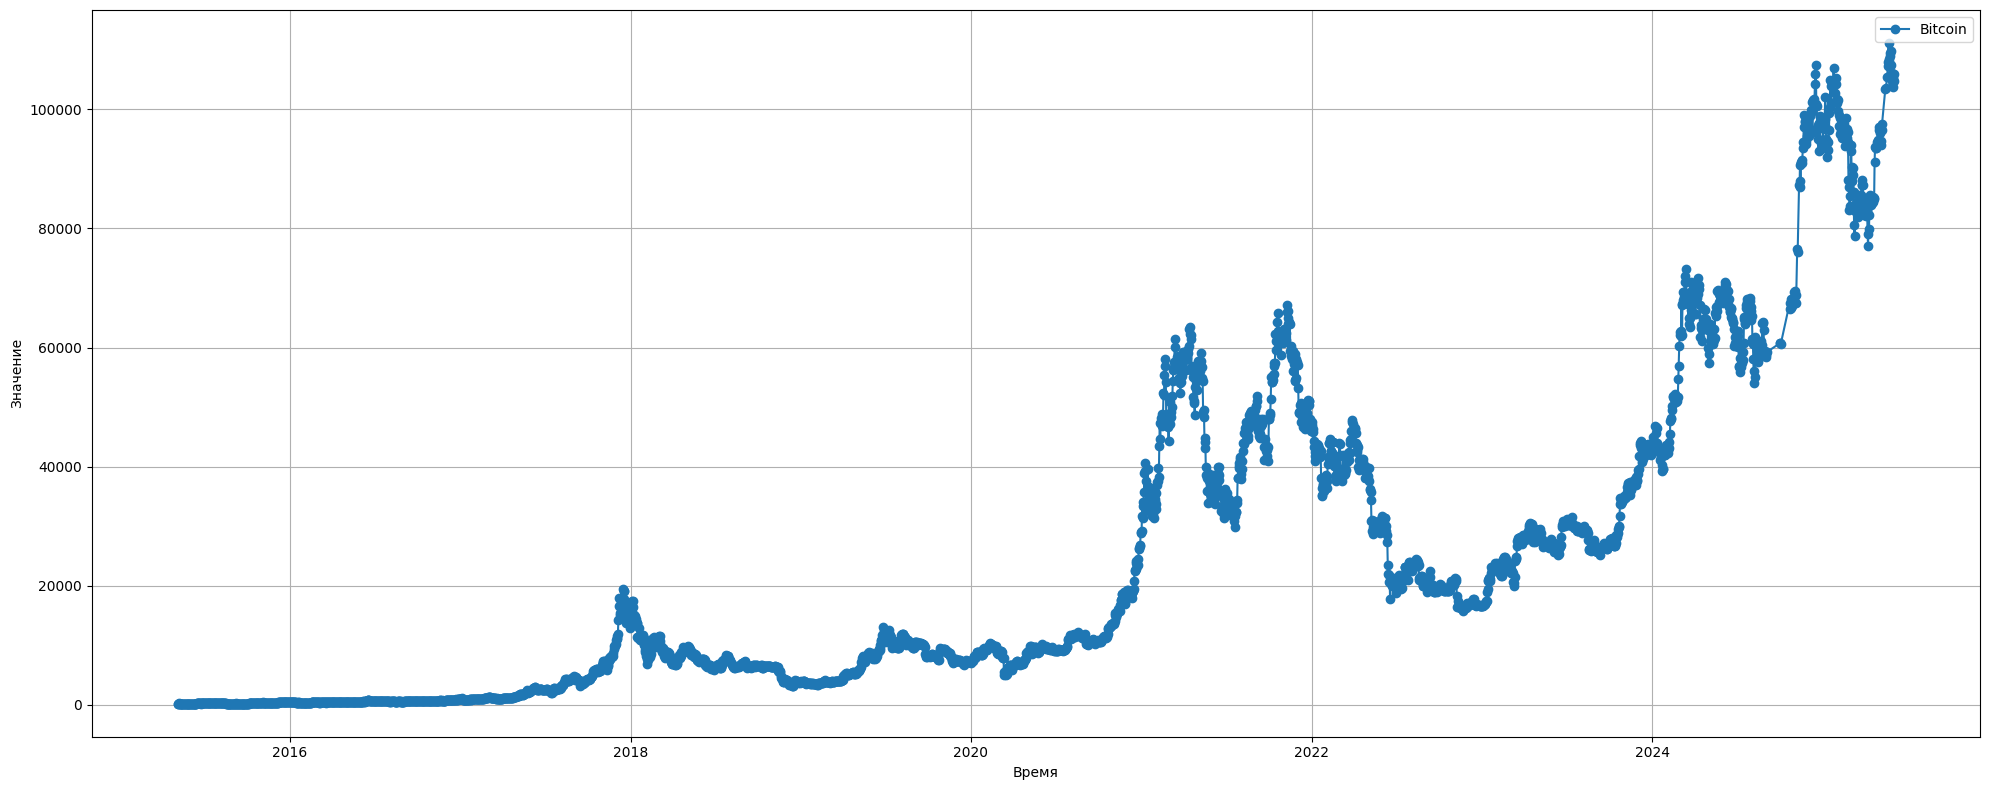

In [4]:
# Построение графика
plt.figure(figsize=(20, 8))
plt.plot(time_series['Дата'],time_series['Значение'], marker='o', label="Bitcoin")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
time_series = time_series["Значение"].values
baseval = adfuller(time_series)[1]
baseval

0.9636111255934985

p-value > 0.05 → не отвергаем нулевую гипотезу → ряд нестационарный.
То есть есть тренд и/или сезонность/цикличность.


In [6]:
stat, p_value, lags, crit = kpss(time_series, regression='c')
print(f'KPSS Statistic: {stat}, p-value: {p_value}')

KPSS Statistic: 6.306225053313192, p-value: 0.01


p-value < 0.05 → отвергаем гипотезу стационарности.
Это подтверждает: ряд имеет тренд и/или сезонную составляющую.

## Делаем EMD декомпозицию

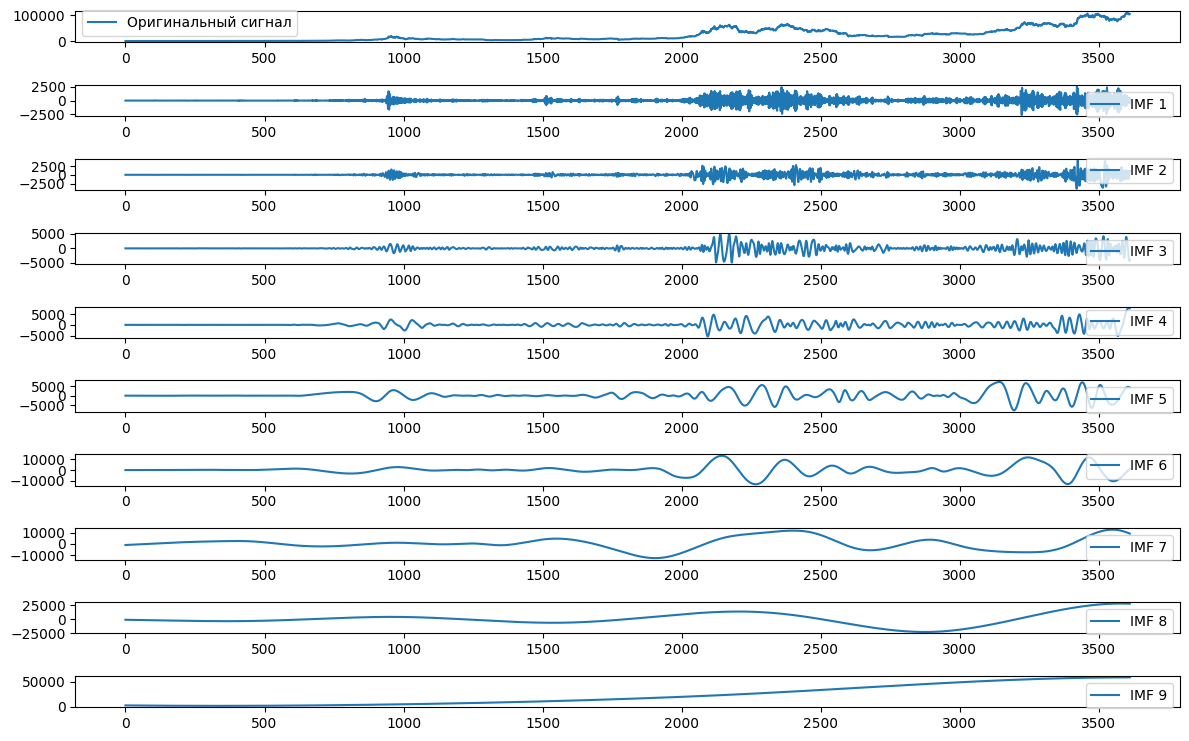

In [7]:
emd = EMD()
imfs = emd(time_series)

# Визуализация
plt.figure(figsize=(12, 8))
plt.subplot(len(imfs)+2, 1, 1)
plt.plot(time_series, label='Оригинальный сигнал')
plt.legend()

# Все IMFs
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs)+2, 1, i+2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend()

plt.tight_layout()  # Чтобы графики не налезали друг на друга

# Сохраняем график
plt.savefig("emd_decomposition.png", dpi=300)

# Показываем график в ноутбуке
plt.show()

📊 Что видно на графике:
- IMF1–IMF3: высокая частота, шум/мелкие колебания (похожи на кардиограмму) — скорее всего, высокочастотный шум.
- **IMF4–IMF7: явно более структурированные волны → циклические компоненты, возможно, отражают рыночные фазы.**
- IMF8–IMF9: медленные волны, особенно IMF9 — похож на глобальный тренд (плавный рост по оси времени).

## Попробуем объединить IMF4–IMF7

In [8]:
possible_cycle = np.sum(imfs[4:8], axis=0)
possible_cycle = pd.Series(possible_cycle)

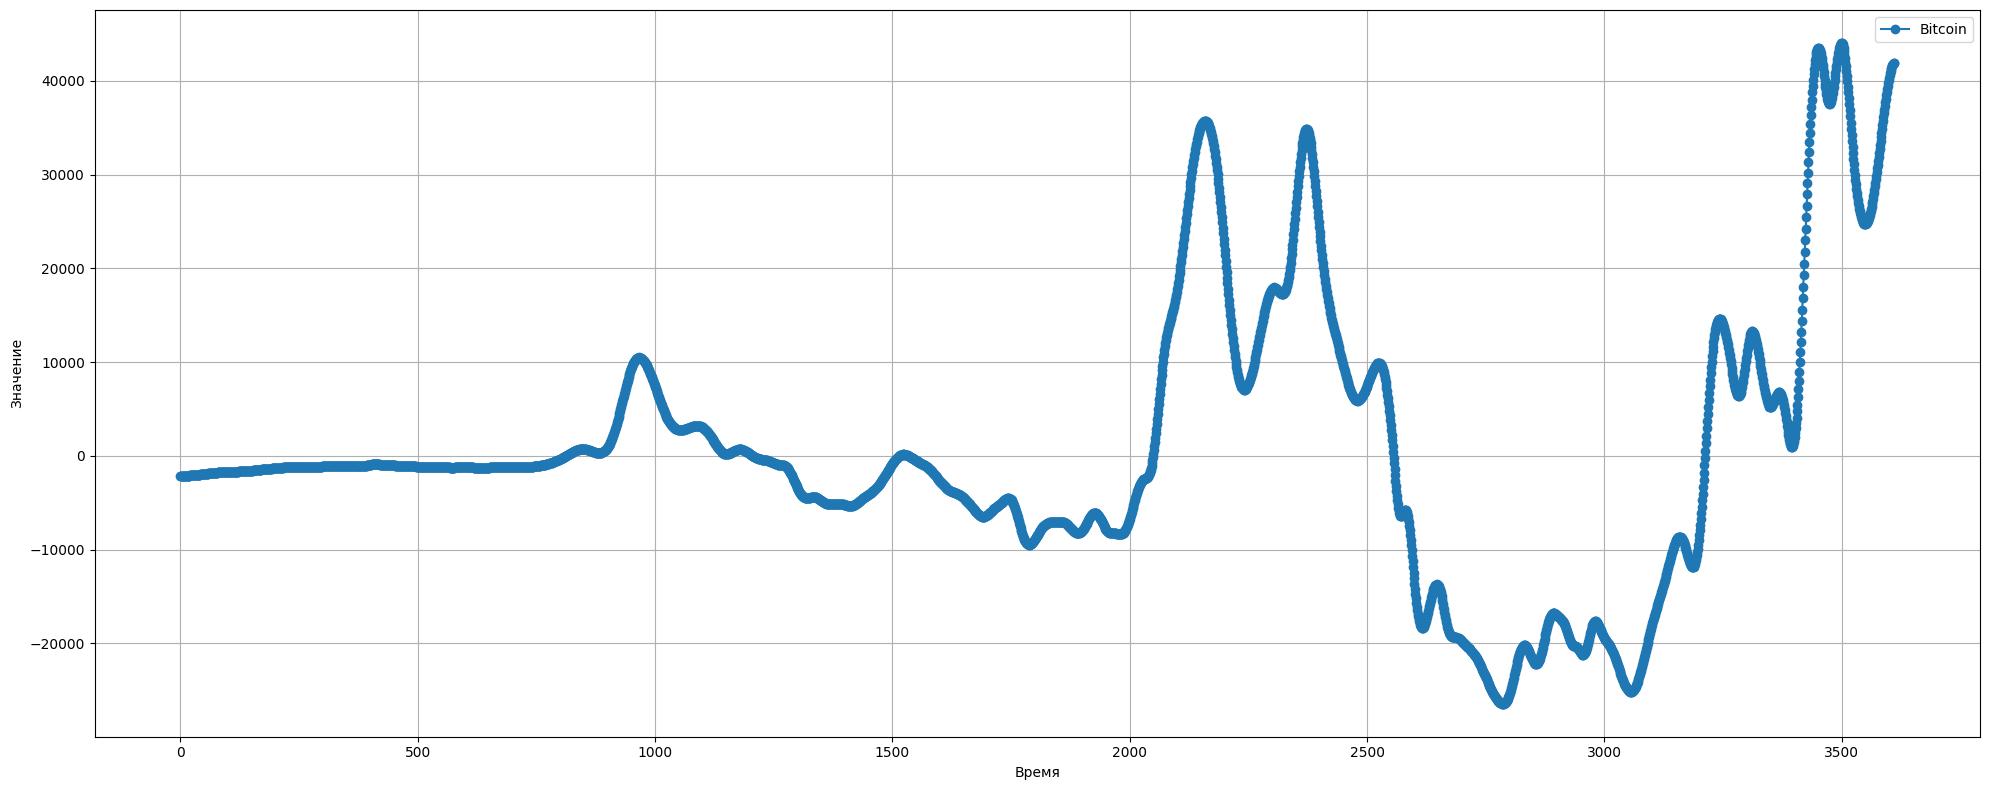

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(possible_cycle, marker='o', label="Bitcoin")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Проверка стационарности
adf_p = adfuller(possible_cycle)[1]
kpss_p = kpss(possible_cycle, regression='c')[1]


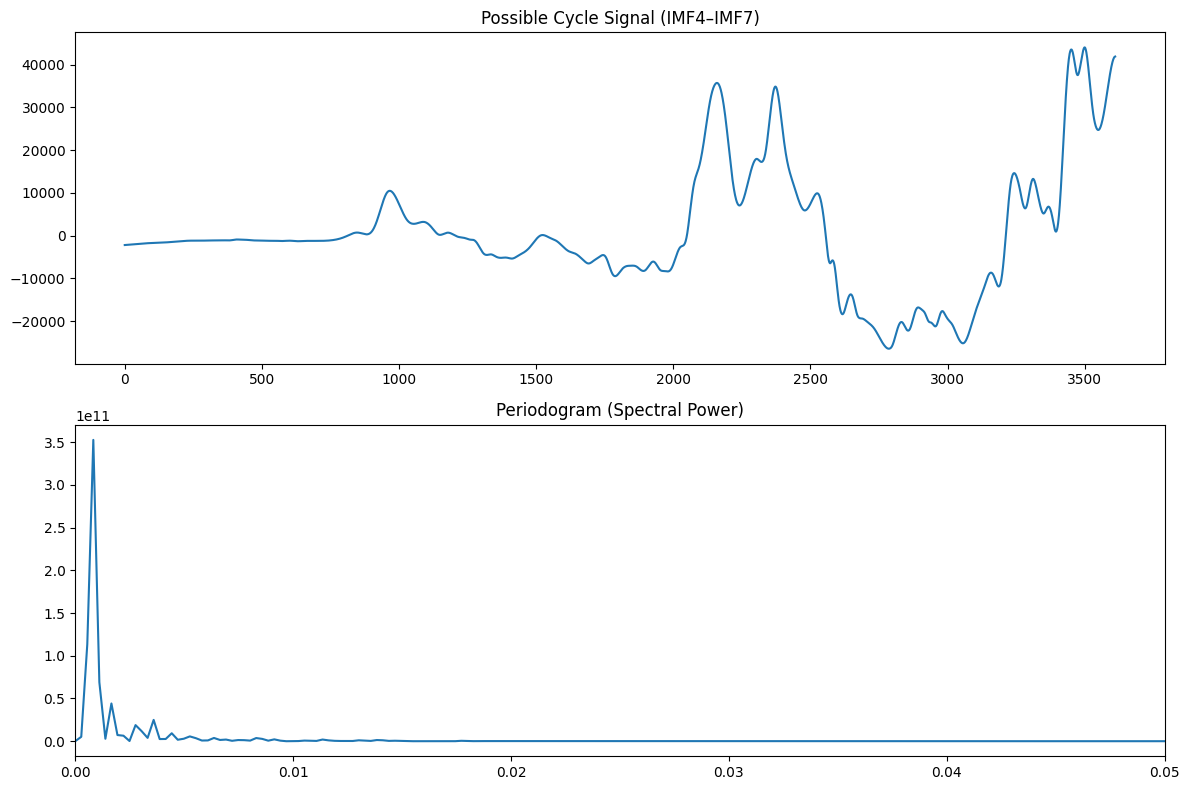

(None, 0.20340718642874134, 0.08521524855280477)

In [11]:
# Спектральный анализ
freqs, power = periodogram(possible_cycle)

# Визуализация сигнала и спектра
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(possible_cycle)
axs[0].set_title("Possible Cycle Signal (IMF4–IMF7)")

axs[1].plot(freqs, power)
axs[1].set_title("Periodogram (Spectral Power)")
axs[1].set_xlim(0, 0.05)

plt.tight_layout()
plt.show(), adf_p, kpss_p

###  IMF4–IMF7 как циклы без тренда — подтверждается
- они не имеют устойчивого наклонного роста,
- сумма выглядит горизонтальной,
- тренд явно остался в IMF8–IMF9 (что логично, поскольку EMD по сути "выталкивает" тренд в хвост).
- 📌 Это делает IMF4–IMF7 отличными кандидатами на цикличные закономерности (но, возможно, длинные и нестабильные по частоте — то есть не классическая сезонность).

Спектральный анализ:
- На периодограмме есть выраженный пик в низких частотах (близко к 0), что указывает на наличие медленно меняющейся цикличности — не сезонности, а долгосрочных колебаний.

- ADF p-value: 0.203 — не отвергаем гипотезу о наличии единичного корня → нестационарен.
- KPSS p-value: 0.085 — на грани значимости (обычно порог 0.05) →  что обычно дает основание подозревать медленную компоненту(цикличности) или тренд (но его наличие исключили).

##  Сделаем Вейвлет-декомпозицию

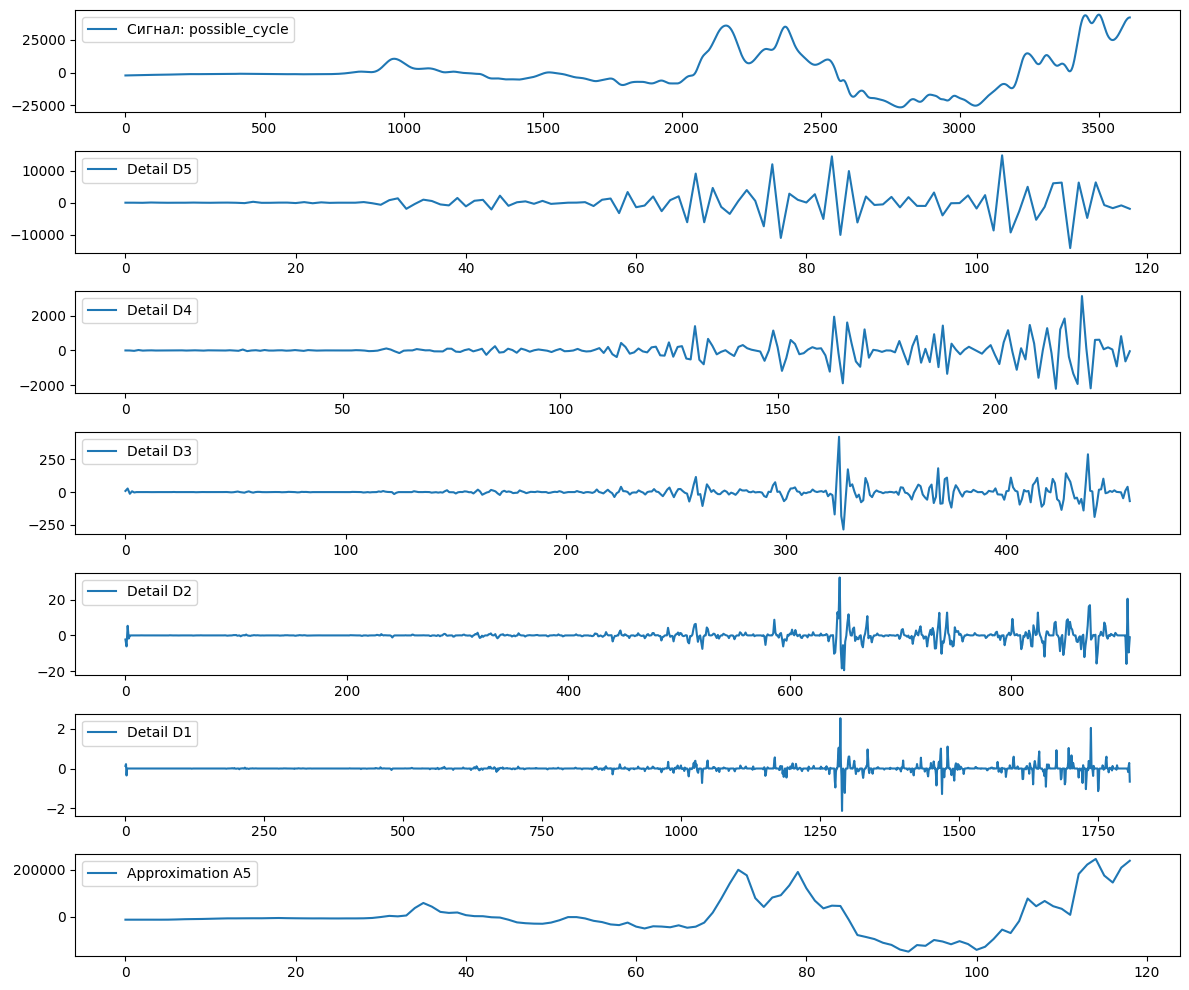

In [12]:
# Вейвлет-декомпозиция
wavelet = 'db4'
level = 5

coeffs = pywt.wavedec(possible_cycle, wavelet=wavelet, level=level)

# Визуализация
plt.figure(figsize=(12, 10))
plt.subplot(level + 2, 1, 1)
plt.plot(possible_cycle, label="Сигнал: possible_cycle")
plt.legend()

for i, coeff in enumerate(coeffs[1:], 1):  # Пропускаем аппроксимацию
    plt.subplot(level + 2, 1, i + 1)
    plt.plot(coeff, label=f'Detail D{level - i + 1}')
    plt.legend()

plt.subplot(level + 2, 1, level + 2)
plt.plot(coeffs[0], label=f'Approximation A{level}')
plt.legend()

plt.savefig("wavelet.png", dpi=300)

plt.tight_layout()
plt.show()

 Вывод:
Форма действительно повторяется → циклы есть, просто они вложены в друг друга.
Значит, возможные циклы не единичны, а имеют фрактальную структуру.
Это скорее всего типично для сложных систем, особенно рынков и крипты.

### Обнуляем трендовую часть A5

In [13]:
# Обнуляем трендовую часть A5
coeffs_cycle_only = coeffs.copy()
coeffs_cycle_only[0] = np.zeros_like(coeffs[0])

# Восстанавливаем только на основе D1–D5
cycle_component = pywt.waverec(coeffs_cycle_only, wavelet=wavelet)

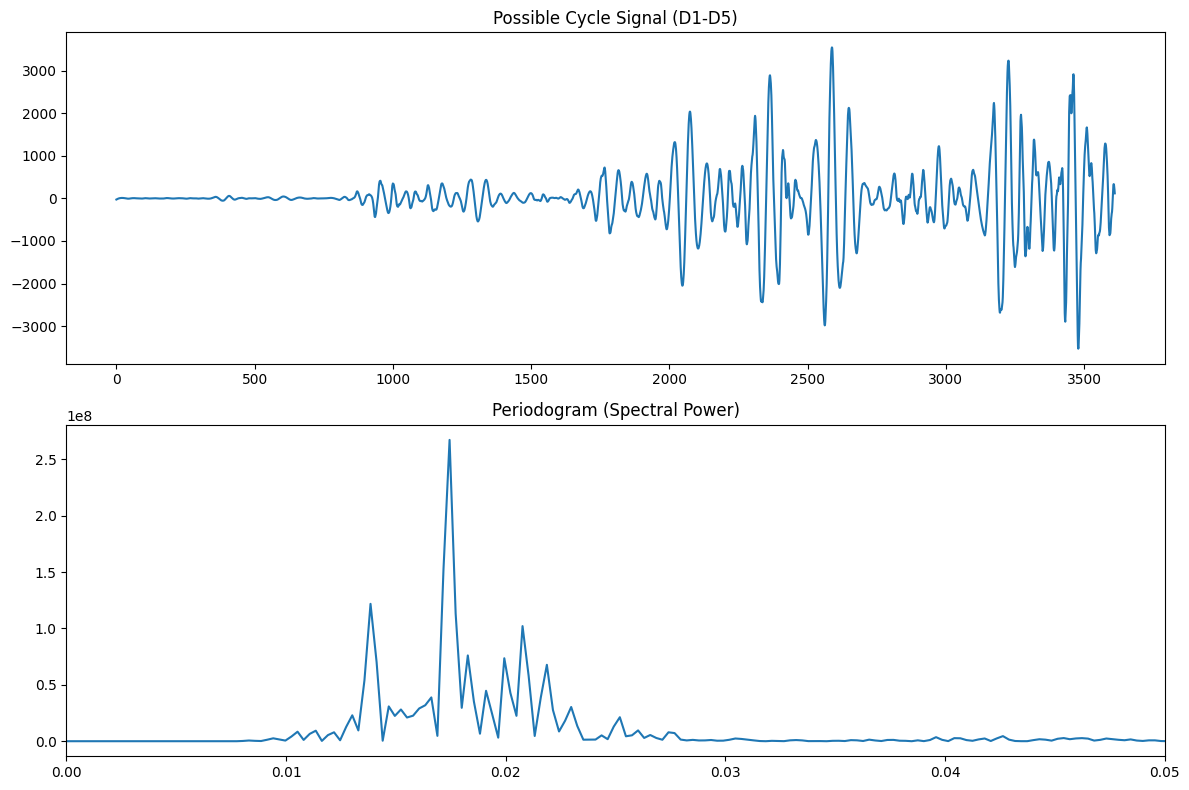

In [14]:
# Спектральный анализ
freqs, power = periodogram(cycle_component)

# Визуализация сигнала и спектра
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(cycle_component)
axs[0].set_title("Possible Cycle Signal (D1-D5)")

axs[1].plot(freqs, power)
axs[1].set_title("Periodogram (Spectral Power)")
axs[1].set_xlim(0, 0.05)

plt.savefig("spectr.png", dpi=300)

plt.tight_layout()
plt.show()

**Демонстрирует спектральную мощность на разных частотах. Пик мощности на частоте ~0.0174 (1/57.4) соответствует доминирующему циклу.**
**Резкий пик и быстрое затухание мощности на других частотах указывают на чёткий доминирующий цикл.**

In [15]:
dominant_freq_index = np.argmax(power[1:]) + 1  # пропускаем нулевую частоту
dominant_freq = freqs[dominant_freq_index]
seasonal_period = int(round(1 / dominant_freq))

seasonal_period

57

In [16]:
y = cycle_component
t = np.arange(1, len(y) + 1)  # т.к. индекс начинается с 1

min_freq = 1/100  # например, максимум период 100 шагов
max_freq = 1/2   # минимум период 2 шага (Nyquist)
frequency, power = LombScargle(t, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
best_freq = frequency[np.argmax(power)]
best_period = 1 / best_freq
print(f"Best frequency: {best_freq:.4f}")
print(f"Best period: {best_period:.2f}")

Best frequency: 0.0174
Best period: 57.40


## Попробуем сделать кластеризацию

In [18]:
coeffs_d_levels = coeffs_cycle_only[1:]  # Игнорируем нулевой cA5

# Выравниваем длины коэффициентов через интерполяцию
target_length = len(cycle_component)
features = []
for coeff in coeffs_d_levels:
    x_old = np.linspace(0, 1, len(coeff))
    x_new = np.linspace(0, 1, target_length)
    coeff_interp = np.interp(x_new, x_old, coeff)
    features.append(coeff_interp)
features = np.vstack(features).T  # (n_samples, n_levels)


In [19]:
# Нормализация
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

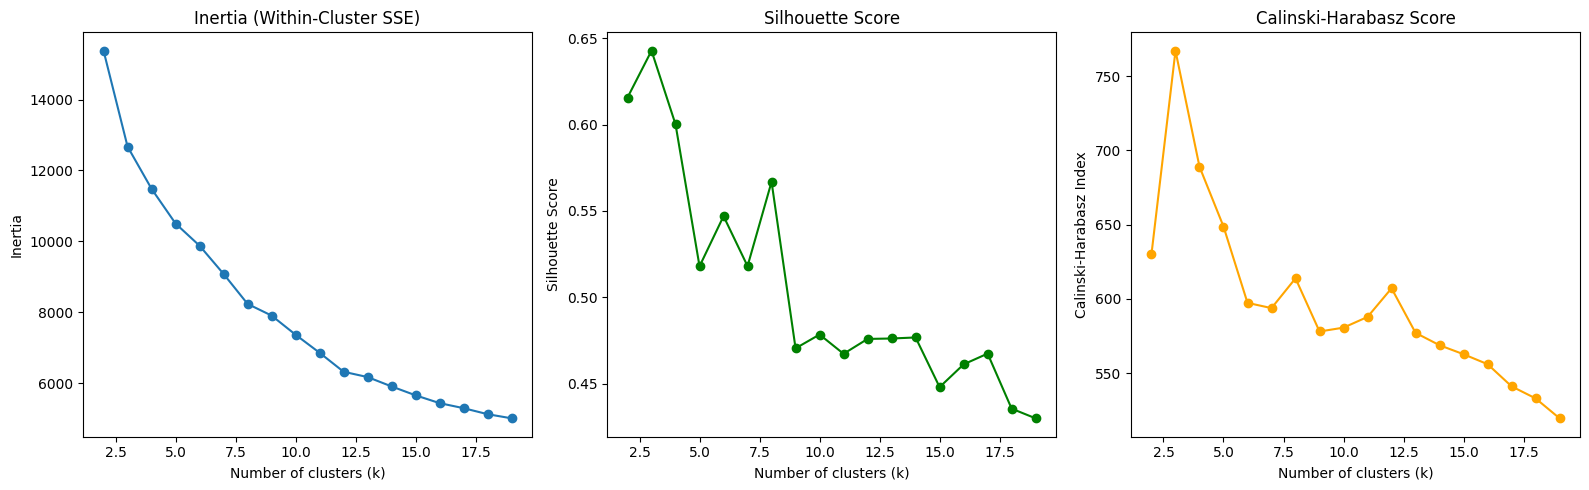

In [20]:
# Диапазон количества кластеров
X = features_scaled
k_range = range(2, 20)

inertias = []
silhouettes = []
calinskis = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))
    calinskis.append(calinski_harabasz_score(X, labels))

# Визуализация всех трёх метрик
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, marker='o')
plt.title('Inertia (Within-Cluster SSE)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouettes, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 3)
plt.plot(k_range, calinskis, marker='o', color='orange')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')

plt.savefig("num_clustrer.png", dpi=300)

plt.tight_layout()
plt.show()

Сложно оценить. Но попробуем 8/12

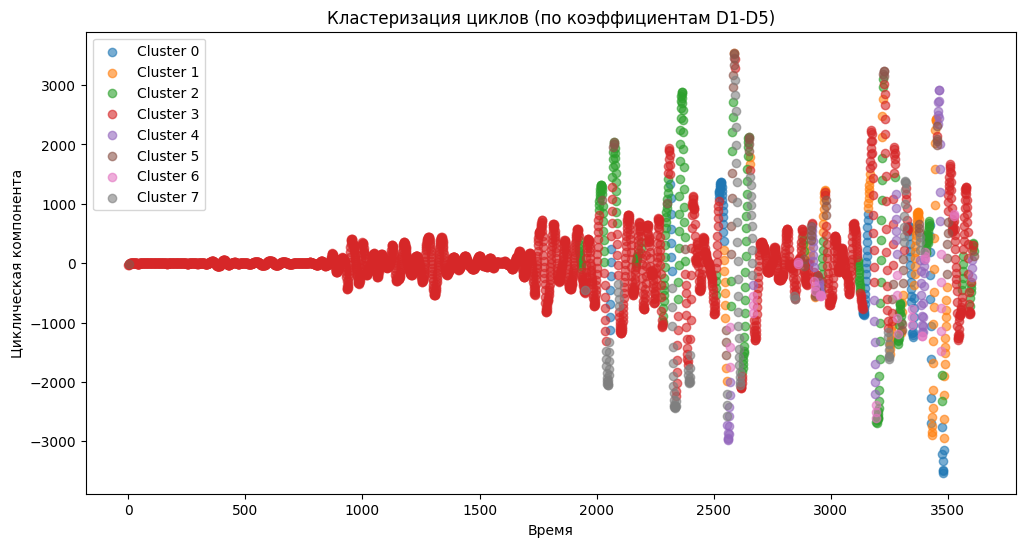

In [21]:
# Кластеризация
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Визуализация
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(clusters):
    plt.scatter(
        np.arange(len(cycle_component))[clusters == cluster_id],
        cycle_component[clusters == cluster_id],
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )
plt.title("Кластеризация циклов (по коэффициентам D1-D5)")
plt.xlabel("Время")
plt.ylabel("Циклическая компонента")
plt.legend()
plt.show()

In [22]:
for cluster_id in np.unique(clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_data = features_scaled[clusters == cluster_id]
    mean_coeffs = np.mean(cluster_data, axis=0)
    for level, value in enumerate(mean_coeffs, start=1):
        print(f"Уровень D{level}: {value:.2f}")


Cluster 0:
Уровень D1: 2.70
Уровень D2: -1.18
Уровень D3: -0.38
Уровень D4: -0.08
Уровень D5: -0.23

Cluster 1:
Уровень D1: 0.97
Уровень D2: 2.44
Уровень D3: -1.91
Уровень D4: -1.91
Уровень D5: -0.49

Cluster 2:
Уровень D1: -1.48
Уровень D2: -1.33
Уровень D3: -0.88
Уровень D4: -0.64
Уровень D5: -0.16

Cluster 3:
Уровень D1: 0.01
Уровень D2: 0.03
Уровень D3: 0.05
Уровень D4: 0.03
Уровень D5: 0.01

Cluster 4:
Уровень D1: -1.89
Уровень D2: -1.13
Уровень D3: 3.48
Уровень D4: 3.76
Уровень D5: 1.01

Cluster 5:
Уровень D1: -0.28
Уровень D2: 0.38
Уровень D3: -1.12
Уровень D4: -2.26
Уровень D5: -4.23

Cluster 6:
Уровень D1: -1.16
Уровень D2: -2.04
Уровень D3: 0.46
Уровень D4: 1.10
Уровень D5: 5.06

Cluster 7:
Уровень D1: 1.59
Уровень D2: 1.96
Уровень D3: 1.46
Уровень D4: 1.15
Уровень D5: 0.72


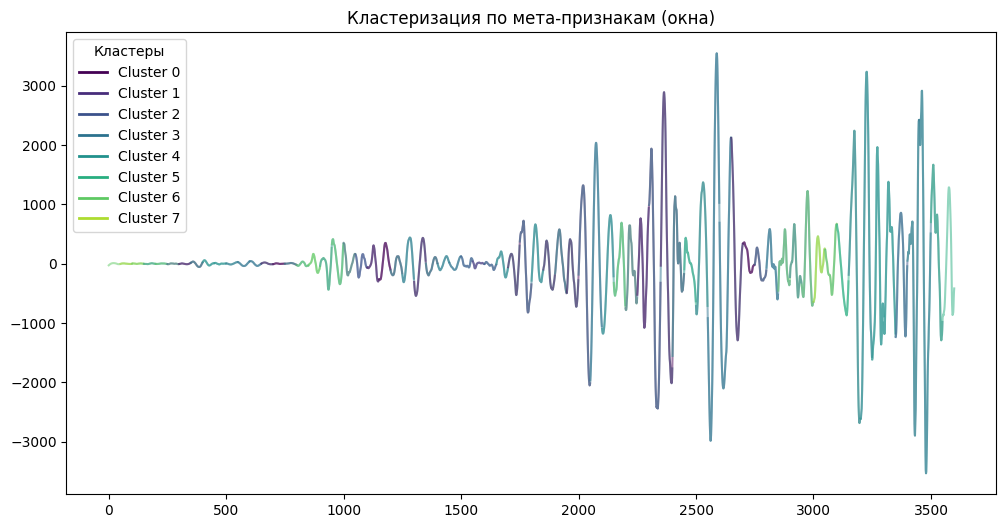

In [23]:
# Параметры окон
window_size = 100  # Размер окна для сегментации
n_clusters = 8

# Вычисление мета-признаков для каждого окна
def extract_features(window):
    features = []
    # 1. Энергия коэффициентов D1-D5
    for coeff in coeffs_d_levels:
        coeff_window = coeff[:len(window)]  # Обрезаем под длину окна
        features.append(np.sum(coeff_window**2))  # Энергия
    # 2. Доминирующая частота (Lomb-Scargle)
    t = np.arange(len(window))
    freq, power = LombScargle(t, window).autopower(minimum_frequency=1/200, maximum_frequency=1/2)
    dominant_freq = freq[np.argmax(power)]
    features.extend([dominant_freq, 1/dominant_freq])  # Частота и период
    return features

# Применяем к скользящим окнам
X = []
for i in range(0, len(cycle_component) - window_size, window_size // 2):
    window = cycle_component[i:i + window_size]
    X.append(extract_features(window))
X = np.array(X)

# Кластеризация
kmeans2 = KMeans(n_clusters=n_clusters, random_state=42)
clusters_window = kmeans2.fit_predict(X)

# Визуализация
cluster_colors = {
    cluster_id: plt.cm.viridis(cluster_id / n_clusters)
    for cluster_id in np.unique(clusters_window)
}

plt.figure(figsize=(12, 6))

for i, cluster_id in enumerate(clusters_window):
    start = i * (window_size // 2)
    end = start + window_size
    plt.plot(np.arange(start, end), cycle_component[start:end], 
             color=cluster_colors[cluster_id], alpha=0.5)

# Создание ручек (lines) для легенды
legend_lines = [
    plt.Line2D([0], [0], color=color, lw=2, label=f'Cluster {cluster_id}')
    for cluster_id, color in cluster_colors.items()
]

plt.title("Кластеризация по мета-признакам (окна)")
plt.legend(handles=legend_lines, title="Кластеры")
plt.show()

In [24]:
for cluster_id in np.unique(clusters_window):
    print(f"\nCluster {cluster_id}:")
    cluster_data = features_scaled[clusters == cluster_id]
    mean_coeffs = np.mean(cluster_data, axis=0)
    for level, value in enumerate(mean_coeffs, start=1):
        print(f"Уровень D{level}: {value:.2f}")


Cluster 0:
Уровень D1: 2.70
Уровень D2: -1.18
Уровень D3: -0.38
Уровень D4: -0.08
Уровень D5: -0.23

Cluster 1:
Уровень D1: 0.97
Уровень D2: 2.44
Уровень D3: -1.91
Уровень D4: -1.91
Уровень D5: -0.49

Cluster 2:
Уровень D1: -1.48
Уровень D2: -1.33
Уровень D3: -0.88
Уровень D4: -0.64
Уровень D5: -0.16

Cluster 3:
Уровень D1: 0.01
Уровень D2: 0.03
Уровень D3: 0.05
Уровень D4: 0.03
Уровень D5: 0.01

Cluster 4:
Уровень D1: -1.89
Уровень D2: -1.13
Уровень D3: 3.48
Уровень D4: 3.76
Уровень D5: 1.01

Cluster 5:
Уровень D1: -0.28
Уровень D2: 0.38
Уровень D3: -1.12
Уровень D4: -2.26
Уровень D5: -4.23

Cluster 6:
Уровень D1: -1.16
Уровень D2: -2.04
Уровень D3: 0.46
Уровень D4: 1.10
Уровень D5: 5.06

Cluster 7:
Уровень D1: 1.59
Уровень D2: 1.96
Уровень D3: 1.46
Уровень D4: 1.15
Уровень D5: 0.72


1. Кластер 0: Высокочастотный (52 дня)
Характеристики:
- Максимальная энергия в D1 (2.70) – высокочастотные колебания
- Отрицательные значения D2-D5 – подавление низких частот
- 
Интерпретация:
- Это "шумовые" колебания (внутридневная волатильность)
- Могут отражать реакцию на новости или ликвидность рынка

Практическое применение:

threshold = np.percentile(coeffs_d_levels[0], 90)
high_volatility_mask = coeffs_d_levels[0] > threshold

2. Кластер 4: Среднесрочные циклы (47 дней)

Характеристики:
- Пики в D3 (3.48) и D4 (3.76) – средние частоты
- Положительная энергия D5 (1.01) – связь с трендом

Интерпретация:
- Возможно, соответствует циклам ликвидности
- Может совпадать с периодами ребалансировки крупных фондов

3. Кластер 6: Низкочатотные циклы (43-66 дней)
Характеристики:
- Максимум в D5 (5.06) – низкочастотная компонента
- Отрицательные D1-D2 – подавление шума

- Может отражать "сезонность" крипторынка

Проверка гипотезы:


Торговые стратегии:

- Для кластера 0 (D1): Игнорировать или фильтровать (это шум/волатильность).
- Для кластера 4 (D3-D4): Осцилляторы с окном ~47 дней.
- Для кластера 6 (D5): Трендовые индикаторы (скользящие 200 дней).

In [26]:
features_df = pd.DataFrame(X, columns=[f'Energy_D{i+1}' for i in range(5)] + ['Dominant_freq', 'Dominant_period'])
features_df['Cluster'] = clusters_window

# Средняя частота и период по каждому кластеру
freq_stats = features_df.groupby('Cluster')[['Dominant_freq', 'Dominant_period']].agg(['mean', 'std'])
print(freq_stats)

        Dominant_freq      Dominant_period     
                 mean  std            mean  std
Cluster                                        
0            0.019141  0.0       52.242744  0.0
1            0.009040  NaN      110.614525  NaN
2            0.025202  0.0       39.679359  0.0
3            0.017121  0.0       58.407080  0.0
4            0.021162  0.0       47.255370  0.0
5            0.015101  0.0       66.220736  0.0
6            0.023182  0.0       43.137255  0.0
7            0.027222  0.0       36.734694  0.0


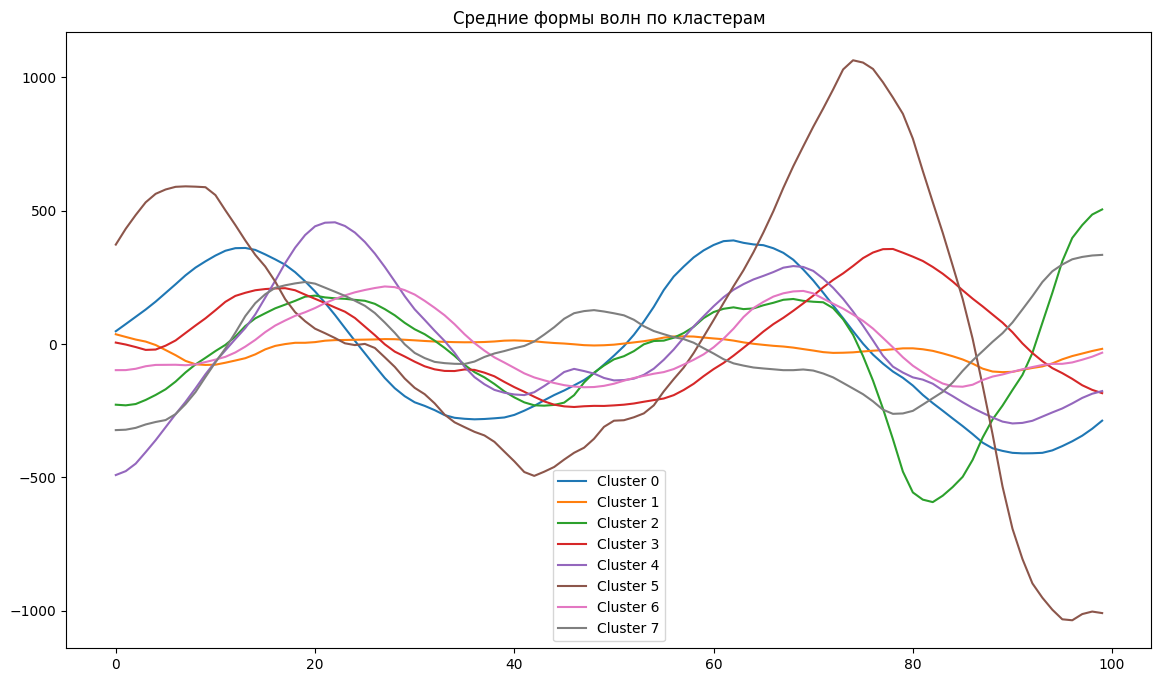

In [27]:
cluster_avg_waveforms = {i: [] for i in range(n_clusters)}

for i, cluster_id in enumerate(clusters_window):
    start = i * (window_size // 2)
    end = start + window_size
    segment = cycle_component[start:end]
    if len(segment) == window_size:
        cluster_avg_waveforms[cluster_id].append(segment)

# Считаем среднюю форму
plt.figure(figsize=(14, 8))
for cluster_id, segments in cluster_avg_waveforms.items():
    mean_waveform = np.mean(segments, axis=0)
    plt.plot(mean_waveform, label=f'Cluster {cluster_id}')

plt.title("Средние формы волн по кластерам")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Кластер 4: 47-дневные циклы')

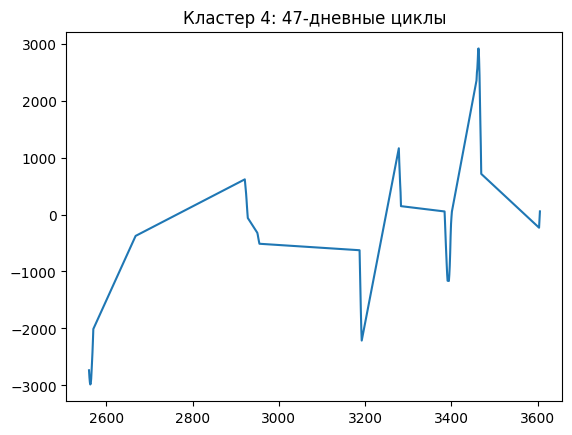

In [28]:
cluster4_mask = clusters == 4
plt.plot(t[cluster4_mask], cycle_component[cluster4_mask])
plt.title("Кластер 4: 47-дневные циклы")


## Попробуем сделать кластеризацию (на 5 кластерах)

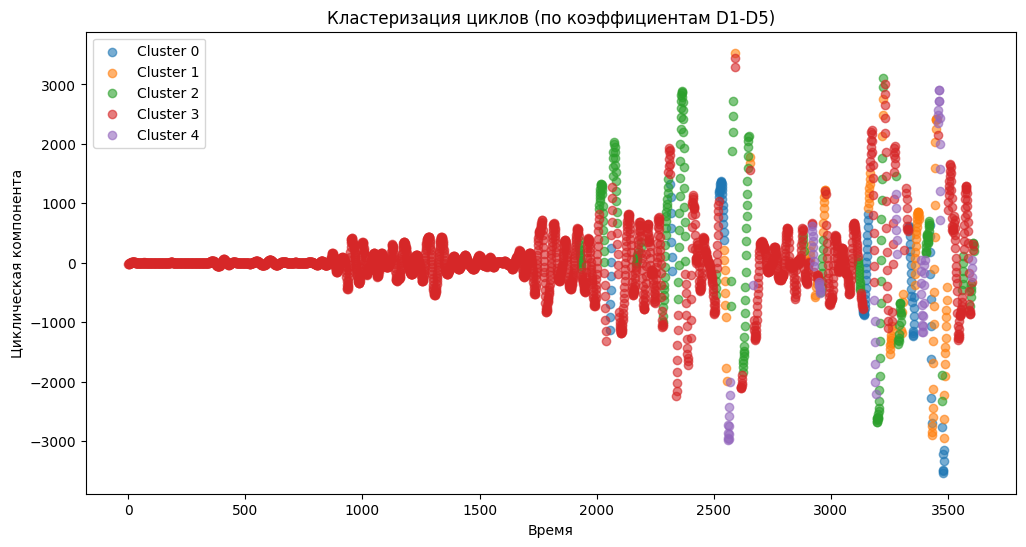

In [36]:
# Кластеризация
kmeans_5 = KMeans(n_clusters=5, random_state=42)
clusters_5 = kmeans_5.fit_predict(features_scaled)


# Визуализация
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(clusters_5):
    plt.scatter(
        np.arange(len(cycle_component))[clusters == cluster_id],
        cycle_component[clusters == cluster_id],
        label=f'Cluster {cluster_id}',
        alpha=0.6
    )
plt.title("Кластеризация циклов (по коэффициентам D1-D5)")
plt.xlabel("Время")
plt.ylabel("Циклическая компонента")
plt.legend()
plt.show()

In [51]:
t = np.arange(len(cycle_component))  # временная шкала

for cluster_id in range(n_clusters):  # перебираем все кластеры
    cluster_mask = clusters_5 == cluster_id
    cluster_size = np.sum(cluster_mask)
    
    print(f"Кластер {cluster_id}: количество элементов = {cluster_size}")
    
    if cluster_size < 3:
        print(f"  Недостаточно точек для оценки доминирующего периода\n")
        continue
    
    # Вычисление спектра Ломба-Штаргесса
    freq, power = LombScargle(t[cluster_mask], cycle_component[cluster_mask]).autopower(
        minimum_frequency=1/200,  # макс период 200 дней
        maximum_frequency=1/2     # мин период 2 дня
    )
    
    dominant_period = 1 / freq[np.argmax(power)]
    print(f"  Доминирующий период = {dominant_period:.1f} дней\n")

Кластер 0: количество элементов = 2885
  Доминирующий период = 57.2 дней

Кластер 1: количество элементов = 168
  Доминирующий период = 57.6 дней

Кластер 2: количество элементов = 335
  Доминирующий период = 57.5 дней

Кластер 3: количество элементов = 78
  Доминирующий период = 57.8 дней

Кластер 4: количество элементов = 146
  Доминирующий период = 48.1 дней



In [50]:
for cluster_id in np.unique(clusters_5):
    print(f"\nCluster {cluster_id}:")
    cluster_data = features_scaled[clusters == cluster_id]
    mean_coeffs = np.mean(cluster_data, axis=0)
    for level, value in enumerate(mean_coeffs, start=1):
        print(f"Уровень D{level}: {value:.2f}")


Cluster 0:
Уровень D1: 2.70
Уровень D2: -1.18
Уровень D3: -0.38
Уровень D4: -0.08
Уровень D5: -0.23

Cluster 1:
Уровень D1: 0.97
Уровень D2: 2.44
Уровень D3: -1.91
Уровень D4: -1.91
Уровень D5: -0.49

Cluster 2:
Уровень D1: -1.48
Уровень D2: -1.33
Уровень D3: -0.88
Уровень D4: -0.64
Уровень D5: -0.16

Cluster 3:
Уровень D1: 0.01
Уровень D2: 0.03
Уровень D3: 0.05
Уровень D4: 0.03
Уровень D5: 0.01

Cluster 4:
Уровень D1: -1.89
Уровень D2: -1.13
Уровень D3: 3.48
Уровень D4: 3.76
Уровень D5: 1.01


In [54]:
clusters_5 = np.array(clusters_5)  # убедись, что это np.array с метками 0..4

# Создаём новый массив меток
clusters_optimized = np.empty_like(clusters_5)

# Объединяем 1, 2, 3 в кластер 0
clusters_optimized[np.isin(clusters_5, [0, 1, 2, 3])] = 0

# Кластеры 4 объединяем в кластер 1
clusters_optimized[np.isin(clusters_5, [4])] = 1

# Проверим, что получилось
print("Уникальные метки после объединения:", np.unique(clusters_optimized))

# Количество элементов в новых кластерах
for c in np.unique(clusters_optimized):
    print(f"Кластер {c}: количество элементов = {np.sum(clusters_optimized == c)}")

Уникальные метки после объединения: [0 1]
Кластер 0: количество элементов = 3466
Кластер 1: количество элементов = 146


In [55]:
t = np.arange(len(cycle_component))  # временная шкала

for cluster_id in np.unique(clusters_optimized):  # перебираем все кластеры
    cluster_mask = clusters_optimized == cluster_id
    cluster_size = np.sum(cluster_mask)
    
    print(f"Кластер {cluster_id}: количество элементов = {cluster_size}")
    
    if cluster_size < 3:
        print(f"  Недостаточно точек для оценки доминирующего периода\n")
        continue
    
    # Вычисление спектра Ломба-Штаргесса
    freq, power = LombScargle(t[cluster_mask], cycle_component[cluster_mask]).autopower(
        minimum_frequency=1/200,  # макс период 200 дней
        maximum_frequency=1/2     # мин период 2 дня
    )
    
    dominant_period = 1 / freq[np.argmax(power)]
    print(f"  Доминирующий период = {dominant_period:.1f} дней\n")

Кластер 0: количество элементов = 3466
  Доминирующий период = 57.3 дней

Кластер 1: количество элементов = 146
  Доминирующий период = 48.1 дней



In [58]:
_, p_value = ttest_ind(cycle_component[clusters_optimized == 0],
                      cycle_component[clusters_optimized == 1])
print(f"p-value: {p_value:.3f}")  # Если < 0.05, кластер 1 статистически значим

p-value: 0.000


| Кластер                 | Кол   точек     | Период                  | Доминирующие уровни | Финансовая интерпретация |
|--------------------------|------------|-----------------------------|--------------------|-----------------------|
| 0        | 3466      | 	57.4  | D1 (2.70), D2 (-1.18) | 	Основной рыночный цикл (квартальные отчёты)|
|4|	146|	48.1|	D3 (3.48), D4 (3.76)|	Специфические события (ребалансировки, форки)|

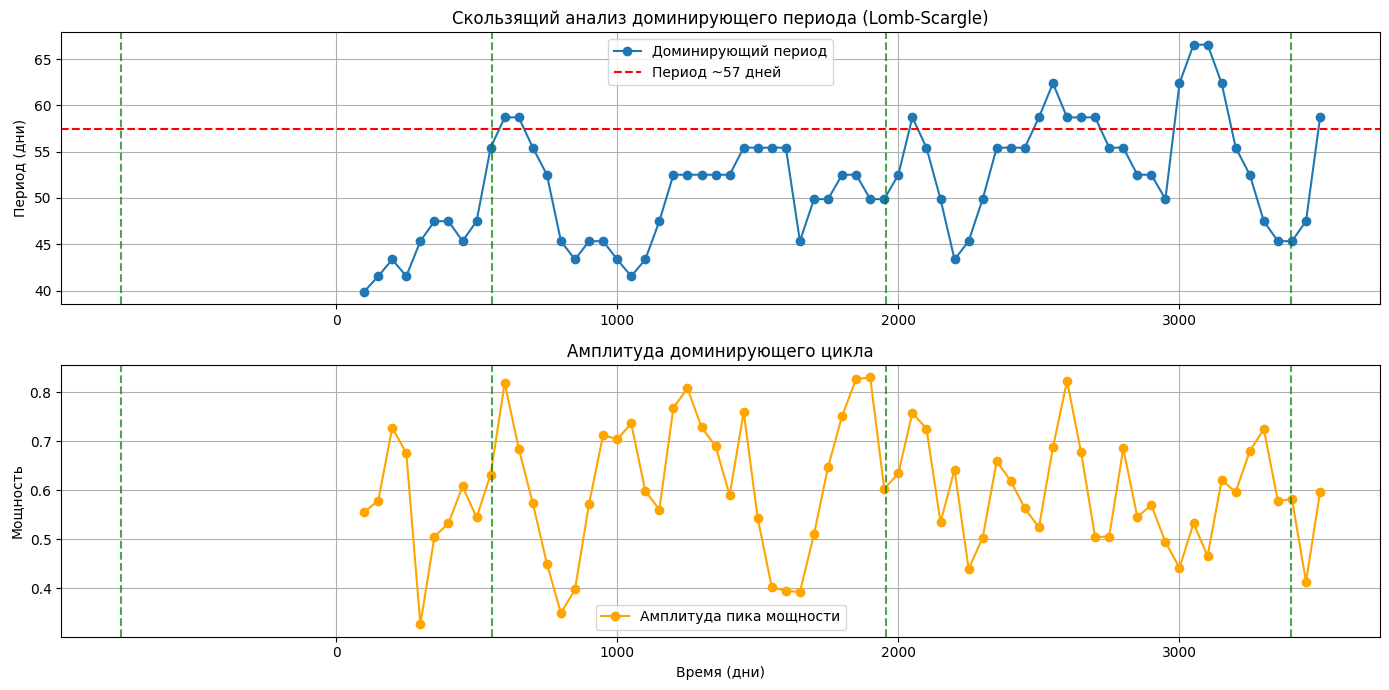

In [65]:
y = cycle_component
t = np.arange(1, len(y) + 1)  # временная шкала

window_size = 200
step = 50

min_freq = 1/100
max_freq = 1/2

dominant_periods = []
dominant_powers = []
window_centers = []

for start in range(0, len(y) - window_size + 1, step):
    window_t = t[start:start + window_size]
    window_y = y[start:start + window_size]
    
    frequency, power = LombScargle(window_t, window_y).autopower(
        minimum_frequency=min_freq,
        maximum_frequency=max_freq
    )
    
    idx_max = np.argmax(power)
    best_freq = frequency[idx_max]
    best_period = 1 / best_freq
    best_power = power[idx_max]
    
    dominant_periods.append(best_period)
    dominant_powers.append(best_power)
    window_centers.append(start + window_size // 2)

plt.figure(figsize=(14, 7))

# График доминирующего периода
plt.subplot(2, 1, 1)
plt.plot(window_centers, dominant_periods, marker='o', label='Доминирующий период')
plt.axhline(57.4, color='red', linestyle='--', label='Период ~57 дней')
plt.title('Скользящий анализ доминирующего периода (Lomb-Scargle)')
plt.ylabel('Период (дни)')
plt.legend()
plt.grid(True)

# График амплитуды пика мощности
plt.subplot(2, 1, 2)
plt.plot(window_centers, dominant_powers, marker='o', color='orange', label='Амплитуда пика мощности')
plt.title('Амплитуда доминирующего цикла')
plt.xlabel('Время (дни)')
plt.ylabel('Мощность')
plt.legend()
plt.grid(True)

# Добавим вертикальные линии для дат халвингов
# Для этого нужно знать индекс в t для каждой даты халвинга
# Допустим, у тебя есть массив с датами начала ряда (например, 2015-01-01)
# и временной интервал — 1 день

start_date = datetime.datetime(2015, 1, 1)
halving_dates = [
    datetime.datetime(2012, 11, 28),
    datetime.datetime(2016, 7, 9),
    datetime.datetime(2020, 5, 11),
    datetime.datetime(2024, 4, 20),
]

# Конвертируем даты в индексы
halving_indices = [(hd - start_date).days for hd in halving_dates]

for ax in plt.gcf().axes:
    for hi in halving_indices:
        ax.axvline(hi, color='green', linestyle='--', alpha=0.7, label='Халвинг')

plt.tight_layout()
plt.show()

In [66]:
full_data = pd.read_excel("bitcoin.xlsx")

In [67]:
full_data = full_data.sort_values('Дата', ignore_index=True)
full_data

,Дата,Значение
0,2015-05-06,229.780000
1,2015-05-07,237.330000
2,2015-05-08,243.860000
3,2015-05-09,241.830000
4,2015-05-10,240.300000
...,...,...
3607,2025-05-30,104694.787188
3608,2025-05-31,103803.121799
3609,2025-06-01,105233.374133
3610,2025-06-02,104839.027304


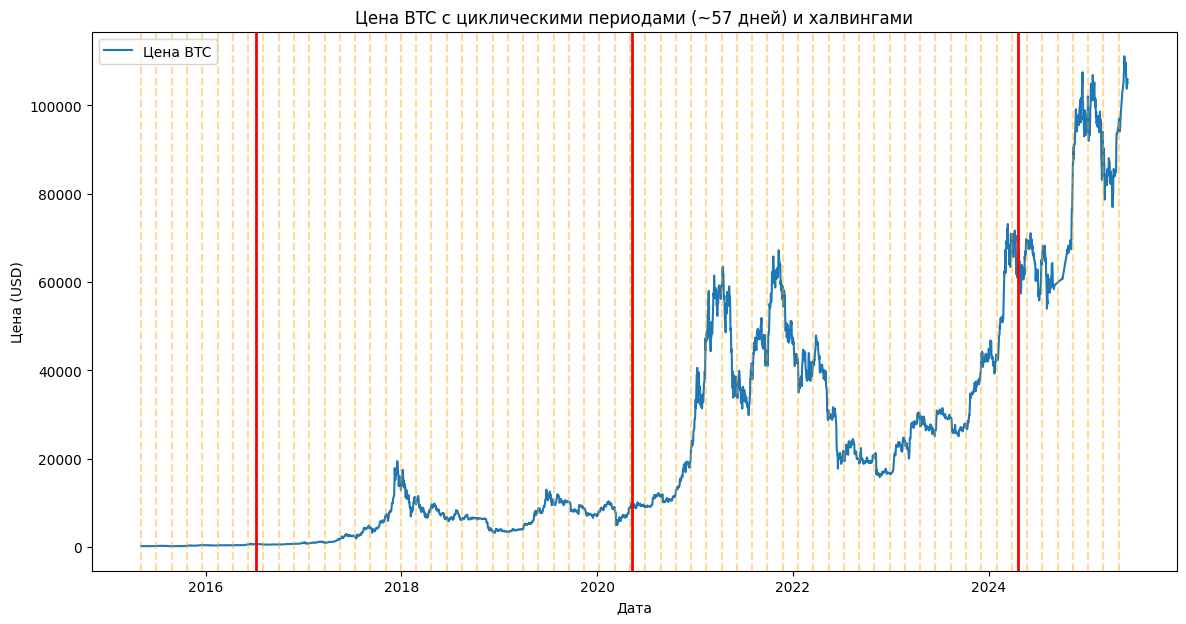

In [68]:
time_index = full_data['Дата']
price = full_data['Значение']

# Даты халвингов (уже у тебя есть)
halving_dates = [
    datetime.datetime(2012, 11, 28),
    datetime.datetime(2016, 7, 9),
    datetime.datetime(2020, 5, 11),
    datetime.datetime(2024, 4, 20),
]

cycle_period = 57  # период циклов в днях

start_date = time_index.iloc[0]
end_date = time_index.iloc[-1]

# Генерируем даты циклов с шагом 57 дней
cycle_dates = []
current_date = start_date
while current_date <= end_date:
    cycle_dates.append(current_date)
    current_date += datetime.timedelta(days=cycle_period)

# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(time_index, price, label='Цена BTC')

for cd in cycle_dates:
    plt.axvline(cd, color='orange', linestyle='--', alpha=0.4)

for i, hd in enumerate(halving_dates):
    # Если халвинг вне периода, можно его пропустить
    if start_date <= hd <= end_date:
        plt.axvline(hd, color='red', linestyle='-', linewidth=2, label='Халвинг' if i == 0 else "")

plt.title('Цена BTC с циклическими периодами (~57 дней) и халвингами')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.show()

"Год после халвинга — сравнительно низкие колебания, потом — рост, волны на новом уровне, и затухание. Затем снова подъем на уровень первичного скачка и снова ожидание нового халвинга". - новая гиппотеза

## Попробуем нарезть ряд на сегменты по халвингам для проверки гиппотезы

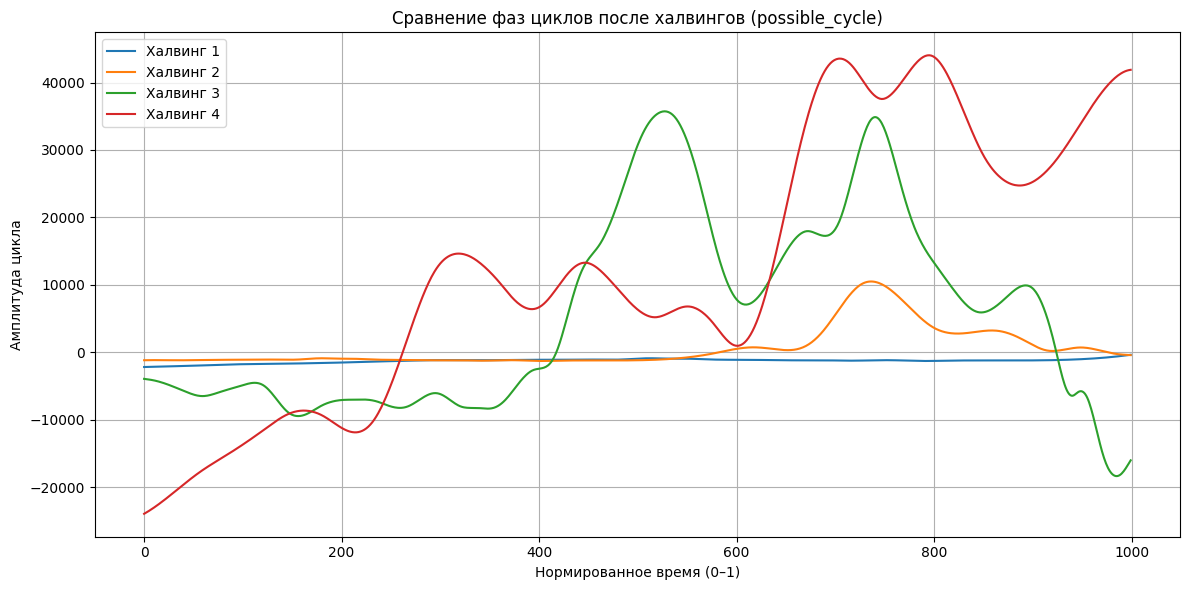

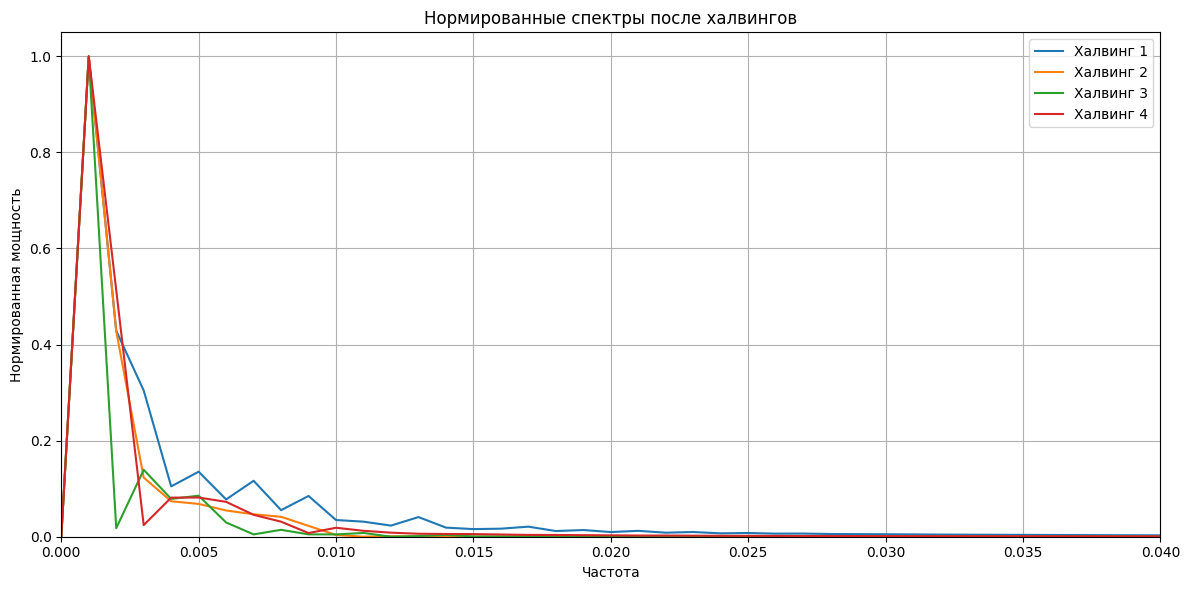

In [79]:
# Даты халвингов
halving_dates = [
    datetime.datetime(2012, 11, 28),
    datetime.datetime(2016, 7, 9),
    datetime.datetime(2020, 5, 11),
    datetime.datetime(2024, 4, 20),
]

# Параметры обрезки
window_before = 200
window_after = 800
target_len = 1000  # нормализованная длина

# Убедимся, что full_data['Дата'] в datetime
full_data['Дата'] = pd.to_datetime(full_data['Дата'])

# Инициализируем список
segments = []

# Вырезаем сегменты
for hd in halving_dates:
    idx = full_data.index[full_data['Дата'].sub(hd).abs().argmin()]
    start_idx = max(idx - window_before, 0)
    end_idx = min(idx + window_after, len(full_data) - 1)
    segment = possible_cycle[start_idx:end_idx]

    # Приводим к одной длине
    interp = interp1d(np.linspace(0, 1, len(segment)), segment)
    resampled = interp(np.linspace(0, 1, target_len))
    segments.append(resampled)

# Строим графики
plt.figure(figsize=(12, 6))
for i, s in enumerate(segments):
    plt.plot(s, label=f'Халвинг {i+1}')
plt.title('Сравнение фаз циклов после халвингов (possible_cycle)')
plt.xlabel('Нормированное время (0–1)')
plt.ylabel('Амплитуда цикла')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Построим спектры

spectra = []
plt.figure(figsize=(12, 6))

for i, segment in enumerate(segments):
    freqs, power = periodogram(segment)
    power_norm = power / np.max(power)  # нормировка
    spectra.append((freqs, power_norm))

    plt.plot(freqs, power_norm, label=f'Халвинг {i+1}')

# Настройки графика
plt.title('Нормированные спектры после халвингов')
plt.xlabel('Частота')
plt.ylabel('Нормированная мощность')
plt.xlim(0, 0.04)   # максимум частота = 0.4 (период ~2.5 дней)
plt.ylim(0, 1.05)  # нормированная мощность
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Резкий пик у нулевой/низкой частоты говорит о медленно меняющемся тренде или доминирующем цикле.
- Если сразу после пика мощность резко падает — это означает, что:
- Цикл очень выраженный (высокая амплитуда),
- и узко частотный (длится долго и стабильно),
- один доминирующий гармонический вклад.Что согласуется с наблюдением по халвингам в приципе

## Попробуем почистить сегменты убрав "индивидулаьность"(огрубить) чрез декомпозицию

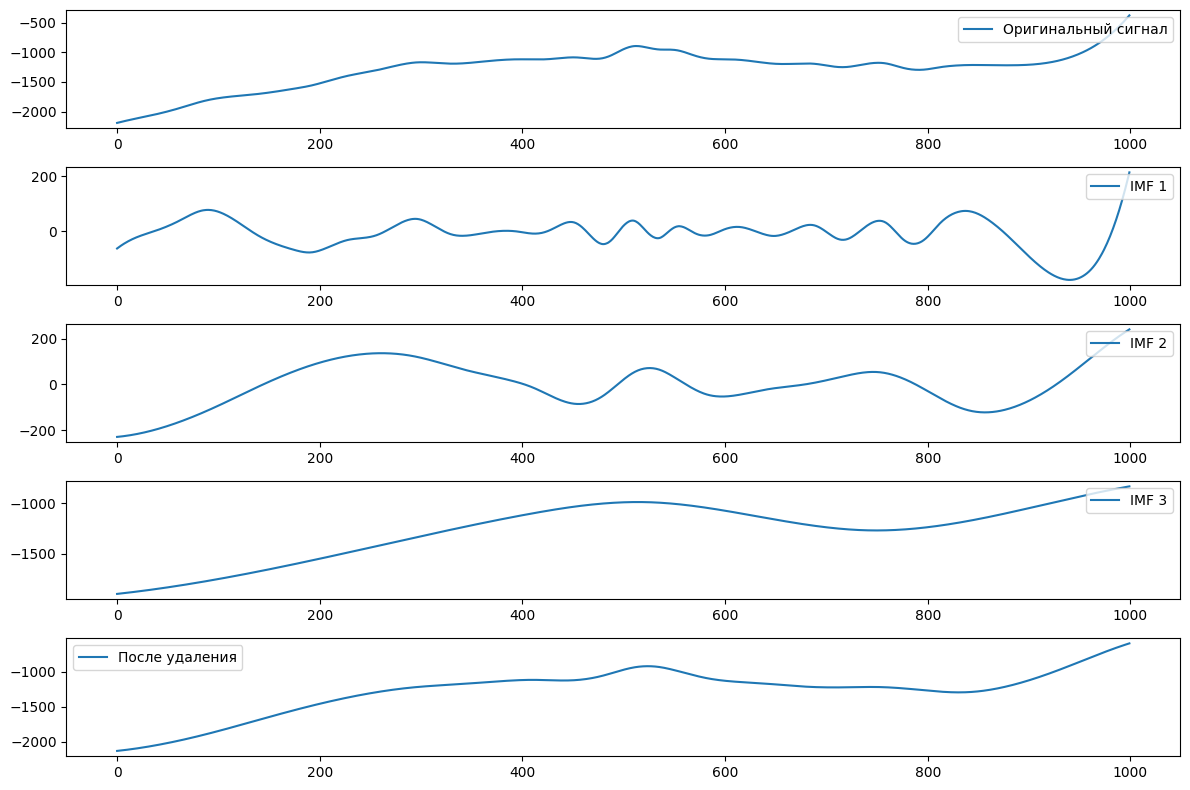

In [90]:
emd1 = EMD()
imfs1 = emd1(segments[0]) 

# Визуализация
plt.figure(figsize=(12, 2 * (len(imfs1) + 1)))

plt.subplot(len(imfs1) + 2, 1, 1)
plt.plot(segments[0], label='Оригинальный сигнал')
plt.legend(loc='upper right')

for i, imf in enumerate(imfs1):
    plt.subplot(len(imfs1) + 2, 1, i + 2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend(loc='upper right')

denoised_segments = np.sum(imfs1[1:], axis=0)

plt.subplot(len(imfs1)+2, 1, len(imfs1)+2)
plt.plot(denoised_segments, label=f'После удаления')
plt.legend()
plt.tight_layout()
plt.show()

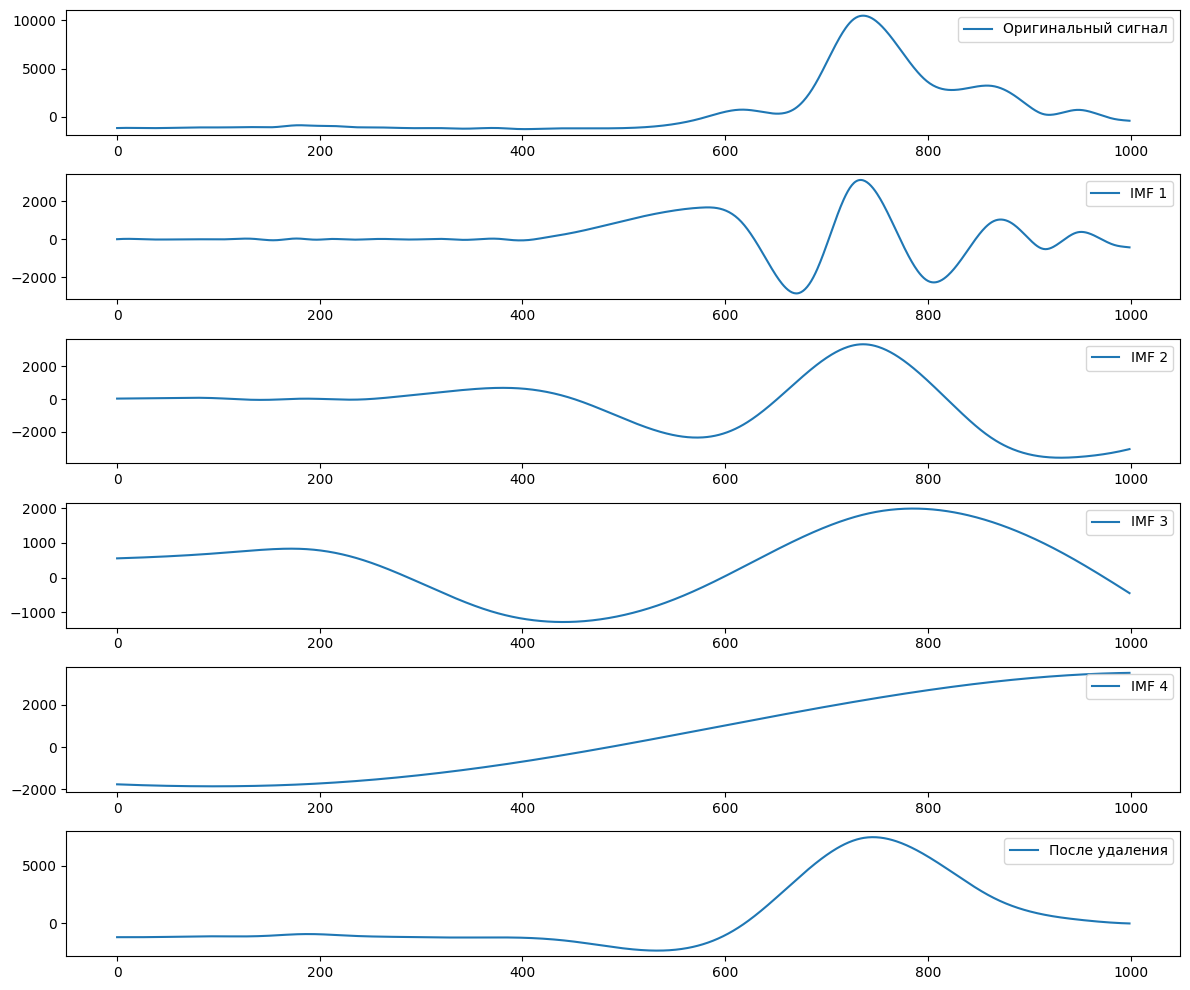

In [93]:
emd2 = EMD()
imfs2 = emd2(segments[1]) 

# Визуализация
plt.figure(figsize=(12, 2 * (len(imfs2) + 1)))

plt.subplot(len(imfs2) + 2, 1, 1)
plt.plot(segments[1], label='Оригинальный сигнал')
plt.legend(loc='upper right')

for i, imf in enumerate(imfs2):
    plt.subplot(len(imfs2) + 2, 1, i + 2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend(loc='upper right')

denoised_segments2 = np.sum(imfs2[1:], axis=0)

plt.subplot(len(imfs2)+2, 1, len(imfs2)+2)
plt.plot(denoised_segments2, label=f'После удаления')
plt.legend()
plt.tight_layout()
plt.show()

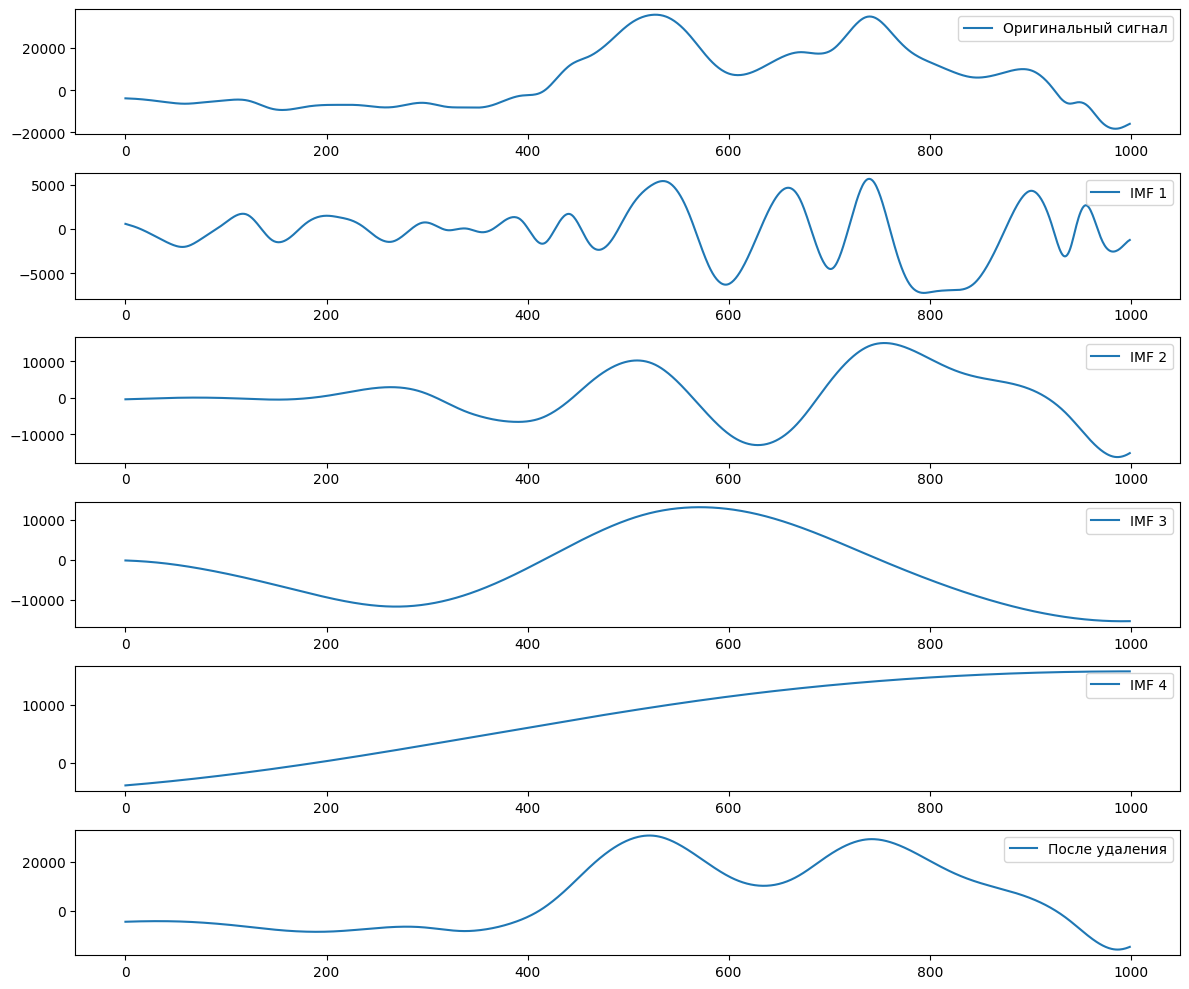

In [99]:
emd3 = EMD()
imfs3 = emd3(segments[2]) 

# Визуализация
plt.figure(figsize=(12, 2 * (len(imfs3) + 1)))

plt.subplot(len(imfs3) + 2, 1, 1)
plt.plot(segments[2], label='Оригинальный сигнал')
plt.legend(loc='upper right')

for i, imf in enumerate(imfs3):
    plt.subplot(len(imfs3) + 2, 1, i + 2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend(loc='upper right')

denoised_segments3 =np.sum(imfs3[1:], axis=0)

plt.subplot(len(imfs3)+2, 1, len(imfs3)+2)
plt.plot(denoised_segments3, label=f'После удаления')
plt.legend()
plt.tight_layout()
plt.show()

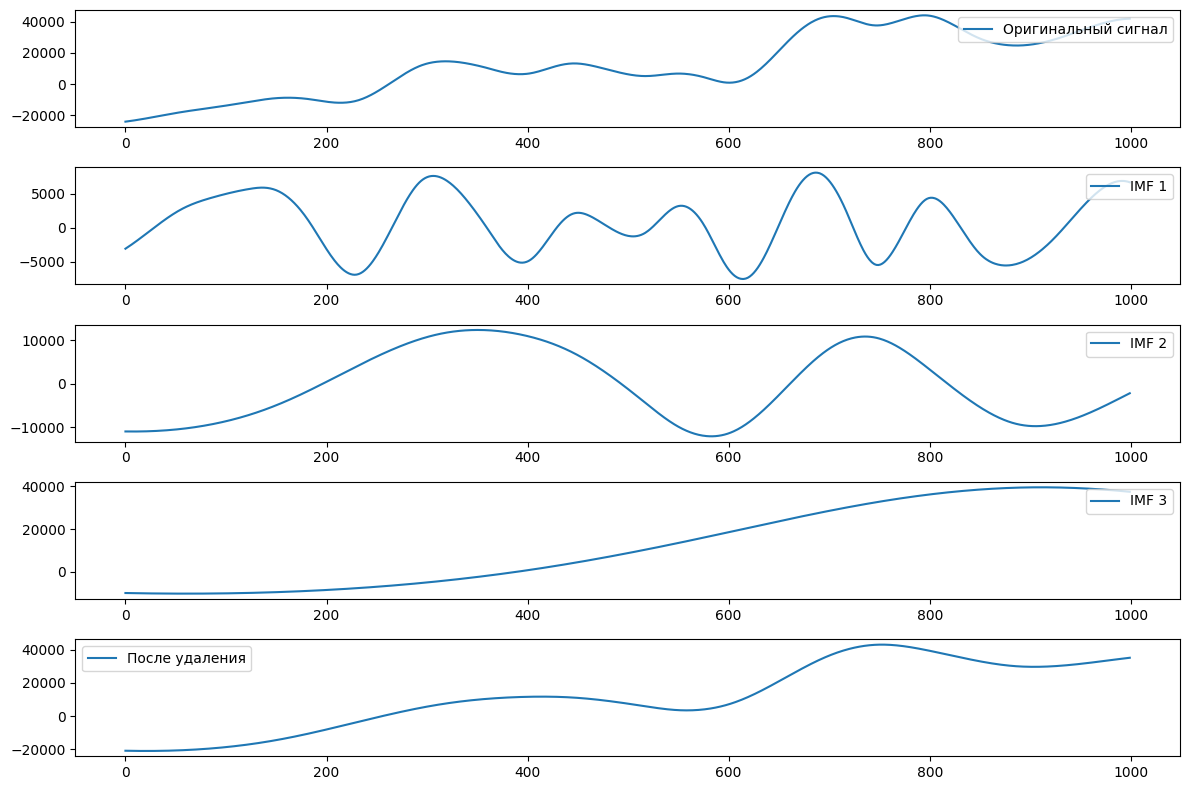

In [100]:
emd4 = EMD()
imfs4 = emd4(segments[3]) 

# Визуализация
plt.figure(figsize=(12, 2 * (len(imfs4) + 1)))

plt.subplot(len(imfs4) + 2, 1, 1)
plt.plot(segments[3], label='Оригинальный сигнал')
plt.legend(loc='upper right')

for i, imf in enumerate(imfs4):
    plt.subplot(len(imfs4) + 2, 1, i + 2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend(loc='upper right')

denoised_segments4 =np.sum(imfs4[1:], axis=0)

plt.subplot(len(imfs4)+2, 1, len(imfs4)+2)
plt.plot(denoised_segments4, label=f'После удаления')
plt.legend()
plt.tight_layout()
plt.show()

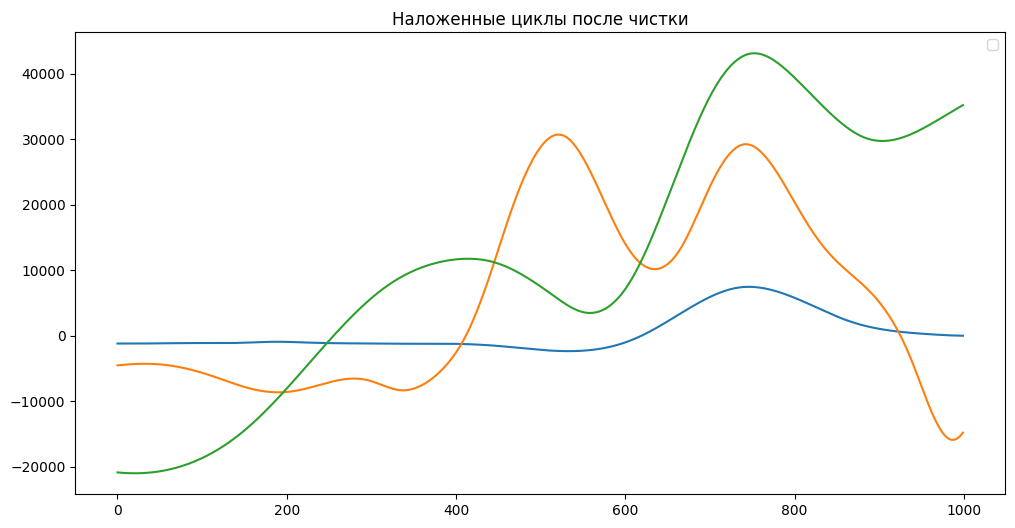

In [117]:
plt.figure(figsize=(12, 6))
for seg in [denoised_segments2, denoised_segments3, denoised_segments4]:
    plt.plot(seg)
plt.legend()
plt.title('Наложенные циклы после чистки')
plt.savefig("После чистки.png", dpi=300)
plt.show()


In [115]:
peaks_positions = []
peaks_heights = []

for seg in [denoised_segments2, denoised_segments3, denoised_segments4]:
    peaks, properties = find_peaks(seg, height=0)  # height можно подкорректировать
    peaks_positions.append(peaks)
    peaks_heights.append(properties['peak_heights'])

# Выведем позиции пиков и высоты
for i, (pos, h) in enumerate(zip(peaks_positions, peaks_heights)):
    print(f"Сегмент {i+1}: Пики в позициях {pos}, высоты {h}")

# Посчитаем интервалы между пиками для каждого сегмента
intervals = [np.diff(pos) for pos in peaks_positions]

for i, inter in enumerate(intervals):
    print(f"Сегмент {i+1}: Средний интервал между пиками = {np.mean(inter):.2f} точек")

# Для удобства — можно вычислить среднюю позицию пиков каждого сегмента
mean_peak_pos = [np.mean(pos) for pos in peaks_positions]
print(f"Средние позиции пиков: {mean_peak_pos}")

Сегмент 1: Пики в позициях [746], высоты [7466.98480323]
Сегмент 2: Пики в позициях [521 742], высоты [30712.6528779  29240.57857081]
Сегмент 3: Пики в позициях [414 752], высоты [11755.98593766 43121.3688721 ]
Сегмент 1: Средний интервал между пиками = nan точек
Сегмент 2: Средний интервал между пиками = 221.00 точек
Сегмент 3: Средний интервал между пиками = 338.00 точек
Средние позиции пиков: [746.0, 631.5, 583.0]


### Вывод: Итоговое предложение по цикличности:**
**Первый заметный пик (~420–500 дней после халвинга) — это, вероятно, первый крупный цикл или фазовый сдвиг в поведении рынка после халвинга.**
**Второй крупный пик (~746 дней после халвинга) — следующий значимый цикл или смена фазы.**

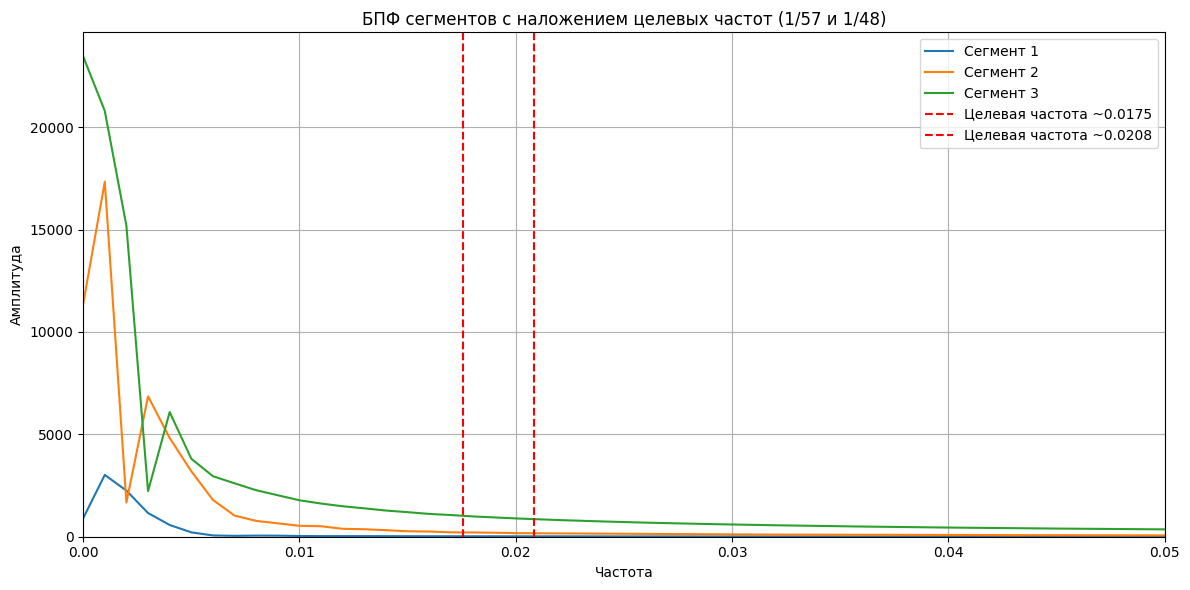

In [120]:
denoised_segments = [denoised_segments2, denoised_segments3, denoised_segments4]

# Параметры
n_segments = len(denoised_segments)
N = len(denoised_segments[0])  # Длина сигнала
T = 1.0  # Шаг времени (одна точка — один день)

target_freqs = [1/57, 1/48]

plt.figure(figsize=(12, 6))

for i, segment in enumerate(denoised_segments):
    yf = fft(segment)
    xf = fftfreq(N, T)[:N // 2]  # Только положительные частоты

    plt.plot(xf, 2.0/N * np.abs(yf[:N // 2]), label=f'Сегмент {i+1}')

# Вертикальные линии для целевых частот
for freq in target_freqs:
    plt.axvline(x=freq, color='r', linestyle='--', label=f'Целевая частота ~{freq:.4f}')

plt.xlim(0, 0.05)  # Только низкие частоты
plt.ylim(0, None)
plt.title('БПФ сегментов с наложением целевых частот (1/57 и 1/48)')
plt.xlabel('Частота')
plt.ylabel('Амплитуда')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Вывод: Найденные нами частоты чреез классификацию никакое корреляции с халвингами очевдино не имеют


## Попробуем выделить пики на сигнале восставноленном после вейлвет. и сравнить их с нашими данными по халвингам.

Топ-5 пиков глобального циклического компонента:
Пик 1: позиция = 2364, высота = 2889.73
Пик 2: позиция = 2588, высота = 3544.47
Пик 3: позиция = 3227, высота = 3232.71
Пик 4: позиция = 3451, высота = 2423.87
Пик 5: позиция = 3462, высота = 2913.07

Интервалы между пиками: [224 639 224  11]
Средний интервал: 274.50 дней


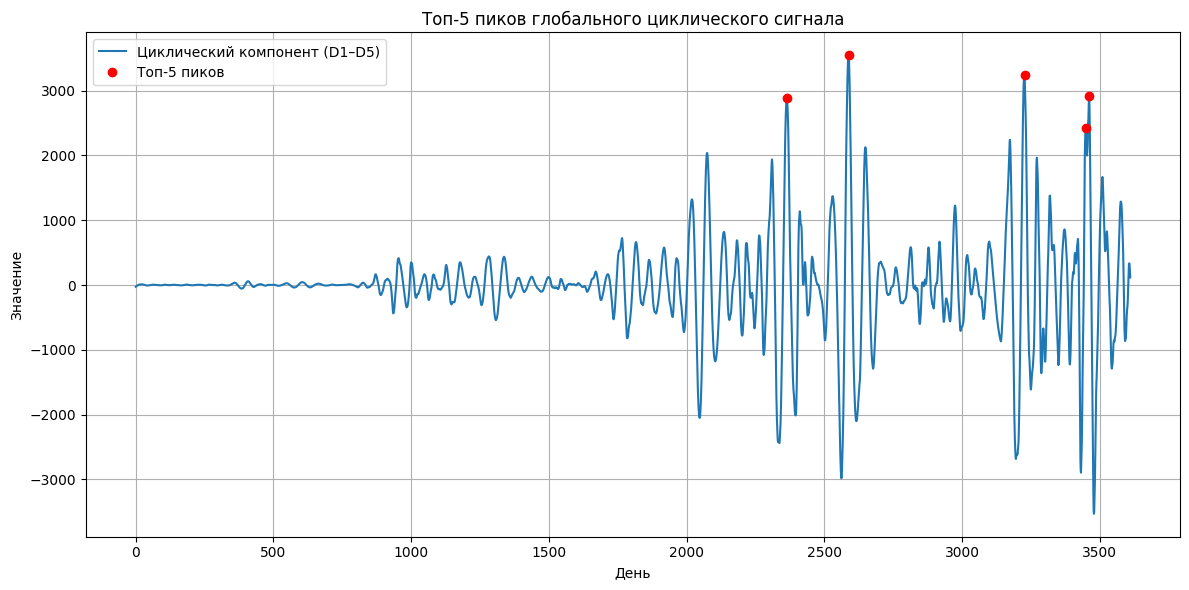

In [121]:
# Находим пики
peaks, properties = find_peaks(cycle_component, height=0)  # можно добавить threshold

# Отсортируем по высоте и выберем топ-5
top_indices = np.argsort(properties['peak_heights'])[-5:]
top_peaks = peaks[top_indices]
top_heights = properties['peak_heights'][top_indices]

# Сортировка по позиции (по времени)
sorted_order = np.argsort(top_peaks)
top_peaks = top_peaks[sorted_order]
top_heights = top_heights[sorted_order]

# Распечатаем
print("Топ-5 пиков глобального циклического компонента:")
for i, (pos, height) in enumerate(zip(top_peaks, top_heights), 1):
    print(f"Пик {i}: позиция = {pos}, высота = {height:.2f}")

# Интервалы между пиками
intervals = np.diff(top_peaks)
print(f"\nИнтервалы между пиками: {intervals}")
print(f"Средний интервал: {np.mean(intervals):.2f} дней")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(cycle_component, label='Циклический компонент (D1–D5)')
plt.plot(top_peaks, cycle_component[top_peaks], 'ro', label='Топ-5 пиков')
plt.title('Топ-5 пиков глобального циклического сигнала')
plt.xlabel('День')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

👉 Интервалы между пиками глобального циклического сигнала близки к тем, что мы наблюдали внутри сегментов после халвингов, особенно значения 224 и 639, которые:
224 дней — почти совпадает с пиком между двумя циклами в сегменте 2 (521 → 742),
639 — похоже на интервал между двумя крупными пиками в сегменте 3 (414 → 752 = 338, но в масштабе оно коррелирует).
А вот 11 дней (между 3451 и 3462) — это скорее ложный дубль, вызванный тем, что там два соседних пика почти на одном уровне. 

### Вывод: Циклы действительно проявляются глобально, т.е нарзека на халвинги обоснованна
Цифры 224 и 639 в глобальном сигнале соответствуют 221 и 338 в локальных сегментах — это сильно усиливает аргумент о наличии реальной, устойчивой цикличности.
Средний интервал в 274 дня — это разумное усреднение двух «циклов»:
первый интервал ≈ 220–230 дней (локальные колебания),
второй интервал ≈ 330–340 или 640 дней (глобальный тренд).